In [2]:
import Plasmon_Modeling as PM
import os,h5py
import numpy as np
from scipy import special as sp
from common.baseclasses import ArrayWithAxes as AWA
import matplotlib.pyplot as plt


In [2]:
class RectangularSample(object):

    def __init__(self,width,height):
        """Initializes the rectangular sample. The established coordinate system on the rectangular mesh is then determined
           as follows.
               -The lower left corner of the sample is considered point (0,0).
               -The height is the y-axis
               -The width is the x-axis
               -All subsequent coordinate values are positive
        Args:
            param1: width, int
            param2: height, int

        Returns:
            RectangularSample object
        """
        self.width = width
        self.height = height
        self.domain = Rectangle(Point(0, 0),
                    Point(width, height))
        self.number_of_objects = 0

    def setDomain(self, in_Domain):
        try:
            self.domain=in_Do   main
            return True
        except:
            raise Exception('Failed to set Domain')

    def getMesh(self,density = 200,to_plot=False):
        """Produces a Fenics Mesh Object from the rectangular sample object

        Args:
            param1: density, kwarg default set to 200, can modify if a denser or sparser mesh is required

        Returns:
            Fenics Mesh Object
        """
        mesh = generate_mesh(self.domain, density)
        if to_plot:
            plt.clf()
            plot(mesh)
            plt.show()
        return mesh

    def placeCircularSource(self,x_pos,y_pos,sourceRadius):
        """Places a circular source, a circular region with dirichlet boundary conditions, at a specified
           coordinate position on the sample.

        Args:
            param1: x_pos, positive x coordinate < width
            param2: y_pos, positive y coordainte < height
            param3: sourceRadius, positive value for the radius of the circular source

        Returns:
            None
        """
        self.number_of_objects += 1
        circ = Circle(Point(x_pos, y_pos), sourceRadius)
        self.domain.set_subdomain(self.number_of_objects, circ)

    def placeCircularReflector(self,x_pos,y_pos,reflectorRadius):
        """Places a circular reflector, a circular region with neumann boundary conditions, at a specified
           coordinate position on the sample.

        Args:
            param1: x_pos, positive x coordinate < width
            param2: y_pos, positive y coordinate < height
            param3: reflectorRadius, positive value for the radius of the circular source

        Returns:
            None
        """
        circ = Circle(Point(x_pos, y_pos), reflectorRadius)
        self.domain-=circ

    def placeRectangularSource(self,x_pos,y_pos,width, height, angle):
        """Places a rectangular source, a rectangular region with dirichlet boundary conditions, at a specified
           coordinate position on the sample. The x_pos and y_pos arguments specify the position of the bottom
           left corner of the rectangular source.

        Args:
            param1: x_pos, positive x coordinate < self.width
            param2: y_pos, positive y coordainte < self.height
            param3: width, postive value for the width of the source
            param4: height, postive value for the height of the source

        Returns:
            None

        """
        self.number_of_objects += 1
        c,s = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array(((c,-s),(s,c)))
        angle_deg = (180/np.pi)*angle

        center = np.array((x_pos+width/2,y_pos+height/2))
        bottom_left = np.array((x_pos,y_pos))
        bottom_right = np.array((x_pos+width,y_pos))
        top_right = np.array((x_pos+width,y_pos+height))
        top_left = np.array((x_pos,y_pos+height))

        rotated_bottom_left = rotation_matrix.dot(bottom_left-center)+center
        rotated_bottom_right = rotation_matrix.dot(bottom_right-center)+center
        rotated_top_right = rotation_matrix.dot(top_right-center)+center
        rotated_top_left = rotation_matrix.dot(top_left-center)+center
        #rec = Rectangle(Point(x_pos,y_pos),
        #            Point(x_pos+width, y_pos+height))
        P1 = Point(list(rotated_bottom_left))
        P2 = Point(list(rotated_bottom_right))
        P3 = Point(list(rotated_top_right))
        P4 = Point(list(rotated_top_left))
        rec = Polygon((P1,P2,P3,P4))
        #rec = CSGRotation(CSGGeometry(rec),angle_deg, Point(x_pos+width/2,y_pos+height/2))
        self.domain.set_subdomain(self.number_of_objects, rec)

    #the position placement is dependent on the bottom left hand corner
    def placeRectangularReflector(self,x_pos,y_pos,width, height, angle):
        """Places a rectangular reflector, a rectangular region with neumann boundary conditions, at a specified
           coordinate position on the sample. The x_pos and y_pos arguments specify the position of the bottom
           left corner of the rectangular reflector.

        Args:
            param1: x_pos, positive x coordinate < self.width
            param2: y_pos, positive y coordainte < self.height
            param3: width, postive value for the width of the reflector
            param4: height, postive value for the height of the reflector

        Returns:
            None

        """
        self.number_of_objects += 1
        c,s = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array(((c,-s),(s,c)))
        angle_deg = (180/np.pi)*angle

        center = np.array((x_pos+width/2,y_pos+height/2))
        bottom_left = np.array((x_pos,y_pos))
        bottom_right = np.array((x_pos+width,y_pos))
        top_right = np.array((x_pos+width,y_pos+height))
        top_left = np.array((x_pos,y_pos+height))

        rotated_bottom_left = rotation_matrix.dot(bottom_left-center)+center
        rotated_bottom_right = rotation_matrix.dot(bottom_right-center)+center
        rotated_top_right = rotation_matrix.dot(top_right-center)+center
        rotated_top_left = rotation_matrix.dot(top_left-center)+center
        #rec = Rectangle(Point(x_pos,y_pos),
        #            Point(x_pos+width, y_pos+height))
        P1 = Point(list(rotated_bottom_left))
        P2 = Point(list(rotated_bottom_right))
        P3 = Point(list(rotated_top_right))
        P4 = Point(list(rotated_top_left))
        rec = Polygon((P1,P2,P3,P4))
        #rec = Rectangle(Point(x_pos, y_pos),
        #            Point(x_pos+width, y_pos+height))
        self.domain-=rec

    def placePolygonalSource(self, vertices):
        self.number_of_objects += 1
        points = []

        for vertex in vertices:
            points.append(Point(vertex[0],vertex[1]))

        rec = Polygon(points)
        self.domain.set_subdomain(self.number_of_objects, rec)

    def placePolygonalReflector(self, vertices):
        points = []

        for vertex in vertices:
            points.append(Point(vertex[0],vertex[1]))

        rec = Polygon(points)
        self.domain-=rec

    def set_boundary_conditions(self, function_space, dim = 1, density = 200):
        """Uses the generate mesh functionality in order to set boundary conditions before a run.

           **A bit buggy, run already sets the boundary conditions when it goes so this code isn't
             normally used**

        Args:
            param1: function_space, FEniCS function space for the boundary condition to e
            param2: dim, kwarg default set to 1, the dimension of the function space
            param3: density, kwarg default set to 200, the density of the auto-generated mesh

        Returns:
            None

        """
        defined_mesh = self.getMesh(density=density)
        self.boundary_markers = MeshFunction('size_t', defined_mesh, 2, mesh.domains())
        self.boundaries = MeshFunction('size_t', defined_mesh, 1, mesh.domains())

        # Use the cell domains associated with each facet to set the boundary
        for f in facets(defined_mesh):
            domains = []
            for c in cells(f):
                domains.append(self.boundary_markers[c])

            domains = list(set(domains))
            if len(domains) > 1:
                self.boundaries[f] = 2

        #assumes dim = 1
        bc_O_value = Constant(0.0,cell=defined_mesh.ufl_cell())
        bc_I_value = Constant(1.0,cell=defined_mesh.ufl_cell())

        #Will modify for a mixed function space
        if (dim == 2):
            bc_O_value = (bc_O_value,bc_O_value)
            bc_I_value = (bc_I_value,bc_I_value)

        def u0_boundary(x, on_boundary):
            return on_boundary

        print(bc_O_value)
        print(bc_I_value)

        bc_O = DirichletBC(function_space, bc_O_value, u0_boundary)

        bc_I = DirichletBC(function_space, bc_I_value, self.boundaries, 2)

        return [bc_O,bc_I]

    def run(self,omega, sigma, to_plot=False, density = 200, _lam=1, _phi=2*pi):
        """Solves the plasmon wave equation on the pre-defined sample. Requires input omega and sigma objects
           that are the parameters for the plasmon wave equation.

        Args:
            param1: omega, object that encapsulates the kappa and V parameters of the wave equation
            param2: sigma, object that encapsulates the lambda and L parameters of the wave equation
            param3: to_plot, kwarg default = False, if True will print out what the real and imaginary
                    parts of the function look like
            param4: density, kwarg default set to 200, the density of the auto-generated mesh

        Returns:
            a FEniCS function that represents the solution to the wave equation

        """
        set_log_level(16)
        mesh = self.getMesh(density)
        L3 = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
        V = MixedElement([L3,L3])
        ME = FunctionSpace(mesh,V)

        # Define boundaries
        boundary_markers = MeshFunction('size_t', mesh, 2, mesh.domains())
        boundaries = MeshFunction('size_t', mesh, 1, mesh.domains())

        # Use the cell domains associated with each facet to set the boundary
        for f in facets(mesh):
            domains = []
            for c in cells(f):
                domains.append(boundary_markers[c])

            domains = list(set(domains))
            if len(domains) > 1:
                boundaries[f] = 2

        def u0_boundary(x, on_boundary):
            return on_boundary

        #Establishing the Boundary Conditions

        bc_O = DirichletBC(ME, (Constant(0.0),Constant(0.0)), u0_boundary)

        #g = Expression('cos((2*pi/lam)*cos(phi)*x[0]+(2*pi/lam)*sin(phi)*x[1])', degree = 1, phi=_phi, lam=_lam)
        g = Expression(('cos( (2*pi/lam)*(cos(phi)*x[0]+sin(phi)*x[1]) )','cos( (2*pi/lam)*(cos(phi)*x[0]+sin(phi)*x[1]) )'),
            element = ME.ufl_element(), phi=_phi, lam=_lam)
        bc_I = DirichletBC(ME,g, boundaries, 2)
        #bc_I = DirichletBC(ME,(Constant(1.0),(Constant(1.0))), boundaries, 2)

        s_1,s_2 = sigma.get_sigma_values()
        o = omega.get_omega_values()

        #trial and test functions
        q,v = TestFunctions(ME)

        # Define functions
        u = TrialFunction(ME) # current
        z = Function(ME)

        # Split mixed functions
        u_1,u_2 = split(u)

        # u_init = InitialConditions(degree = 1)
        # u.interpolate(u_init)

        s_1 = Constant(s_1)
        s_2 = Constant(s_2)
        o = Constant(o)


        #TODO FOR ALEX, SIGN IN FRONT OF O, NOT PRODUCING WAVES
        F0 = (s_1*s_1+s_2*s_2)*dot(grad(u_1), grad(q))*dx+o*(s_1*u_2-s_2*u_1)*q*dx
        F1 = (s_1*s_1+s_2*s_2)*dot(grad(u_2), grad(v))*dx-o*(s_1*u_1+s_2*u_2)*v*dx
        F = F0 + F1 # + Constant(20.0)*q*ds + Constant(20.0)*v*ds
        a, L = lhs(F), rhs(F)

        print("Attempting to solve:")

        solve(a==L,z,[bc_O,bc_I])

        if to_plot:
            fig = plt.figure()
            plt.subplot(121);mplot(z.split(deepcopy=True)[0]);plt.title("Real Part"),plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,
                right = False,     # ticks along the bottom edge are off
                left = False,
                top=False,         # ticks along the top edge are off
                labelleft=False);plt.colorbar()
            plt.subplot(122);mplot(z.split(deepcopy=True)[1]);plt.title("Im Part"),plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,
                right = False,     # ticks along the bottom edge are off
                left = False,
                top=False,         # ticks along the top edge are off
                labelleft=False);plt.colorbar()

            plt.show()

        self.solution = z

        return z

    def eigenvalue_target_solve(self,eigenvalue,sigma,number_extracted = 6, to_plot = False, density = 200):
        """Uses the SlepcEigensolver to solve the helmholtz equation on the pre-defined sample. Requires a specified eigenvalue
           to "target". Will extract up to number_extracted nearby eigenvalue, eigenvector pairs.

        Args:
            param1: eigenvalue, float, the value that the SlepcEigensolver will attempt to "aim" for.
            param2: sigma, object that contains information on the plasmon wavelength and propagation length
            param3: number_extracted, kwarg default set to 6, will additionally extract 6
                    eigenvalues near the specified eigenvalue.
            param4: to_plot, kwarg default = False, if True will print out what the eigenvectors look like
                    with eigenvalue titles
            param5: density, kwarg default set to 200, the density of the auto-generated mesh

        Returns:
            Dictionary indexed by eigenvalue filled with the appropriate FEniCS function eigenfunctions

        """
        mesh = self.getMesh(density)
        V = FunctionSpace(mesh, 'Lagrange', 3)

        # Define boundaries
        boundary_markers = MeshFunction('size_t', mesh, 2, mesh.domains())
        boundaries = MeshFunction('size_t', mesh, 1, mesh.domains())

        # Use the cell domains associated with each facet to set the boundary
        for f in facets(mesh):
            domains = []
            for c in cells(f):
                domains.append(boundary_markers[c])

            domains = list(set(domains))
            if len(domains) > 1:
                boundaries[f] = 2

        def u0_boundary(x, on_boundary):
            return on_boundary

        #Establishing the Boundary Conditions
        bc = DirichletBC(V, Constant(0.0), u0_boundary)

        bc_I = DirichletBC(V, Constant(1.0), boundaries, 2)

        #define functions
        u = TrialFunction(V)
        v = TestFunction(V)

        #Getting sigma values
        s_1,s_2 = sigma.get_sigma_values()

        #define problem
        Pot = Expression(str(s_2),element = V.ufl_element())
        a = (Pot*inner(grad(u), grad(v)) \
             + u*v)*dx
        m = u*v*dx

        A = PETScMatrix()
        M = PETScMatrix()
        _ = PETScVector()
        L = Constant(0.0)*v*dx

        #bcs = [bc_O,bc_I]

        assemble_system(a, L, bc, A_tensor=A, b_tensor=_)
        #assemble_system(m, L,bc, A_tensor=M, b_tensor=_)
        assemble_system(m, L, A_tensor=M, b_tensor=_)

        #create eigensolver
        eigensolver = SLEPcEigenSolver(A,M)
        eigensolver.parameters['spectrum'] = 'target real'
        eigensolver.parameters['tolerance'] = 1.e-15
        eigensolver.parameters["spectral_transform"] = "shift-and-invert"
        eigensolver.parameters["spectral_shift"] = float(eigenvalue) # Could be a possible spot for overflow

        print(eigenvalue)

        #solve for eigenvalues
        eigensolver.solve(number_extracted)

        assert eigensolver.get_number_converged() > 0

        eigenvalues = []
        eigenfunctions = []

        #returning the eigenvalue, eigenvector pairs
        for i in range(number_extracted):
            u = Function(V)
            r, c, rx, cx = eigensolver.get_eigenpair(i)

            #assign eigenvector to function
            u.vector()[:] = rx
            eigenvalues.append(r)
            eigenfunctions.append(u)
            plt.figure(); plot(u,interactive=True); plt.title("Eigenvalue: {}".format(r))

        return dict(list(zip(eigenvalues,eigenfunctions)))

    def eigenvalue_solve(self,sigma, number_extracted = 6, to_plot = False, density = 200):
        """Uses the SlepcEigensolver to solve the helmholtz equation on the pre-defined sample. Requires a specified eigenvalue
           to "target". Will extract up to number_extracted nearby eigenvalue, eigenvector pairs.

        Args:
            param1: number_extracted, kwarg default set to 6, will additionally extract 6
                    eigenvalues near the specified eigenvalue.
            param2: to_plot, kwarg default = False, if True will print out what the eigenvectors look like
                    with eigenvalue titles
            param3: density, kwarg default set to 200, the density of the auto-generated mesh

        Returns:
            Dictionary indexed by eigenvalue filled with the appropriate FEniCS function eigenfunctions

        """
        mesh = self.getMesh(density)
        V = FunctionSpace(mesh, 'Lagrange', 3)

        # Define boundaries
        boundary_markers = MeshFunction('size_t', mesh, 2, mesh.domains())
        boundaries = MeshFunction('size_t', mesh, 1, mesh.domains())

        # Use the cell domains associated with each facet to set the boundary
        for f in facets(mesh):
            domains = []
            for c in cells(f):
                domains.append(boundary_markers[c])

            domains = list(set(domains))
            if len(domains) > 1:
                boundaries[f] = 2

        def u0_boundary(x, on_boundary):
            return on_boundary

        #Establishing the Boundary Conditions
        bc_O = DirichletBC(V, Constant(0.0), u0_boundary)

        bc_I = DirichletBC(V,Constant(1.0), boundaries, 2)

        #define functions
        u = TrialFunction(V)
        v = TestFunction(V)

        #Getting sigma values
        s_1,s_2 = sigma.get_sigma_values()

        #define problem
        Pot = Expression(str(s_2),element = V.ufl_element())
        a = (inner(grad(u), grad(v)) \
             + Pot*u*v)*dx
        m = u*v*dx

        A = PETScMatrix()
        M = PETScMatrix()
        _ = PETScVector()
        L = Constant(0.)*v*dx

        bcs = [bc_O,bc_I]

        assemble_system(a, L, bcs, A_tensor=A, b_tensor=_)
        #assemble_system(m, L,bc, A_tensor=M, b_tensor=_)
        assemble_system(m, L, A_tensor=M, b_tensor=_)

        #create eigensolver
        eigensolver = SLEPcEigenSolver(A,M)
        eigensolver.parameters['tolerance'] = 1.e-15

        #solve for eigenvalues
        eigensolver.solve(number_extracted)

        assert eigensolver.get_number_converged() > 0

        eigenvalues = []
        eigenfunctions = []

        #returning the eigenvalue, eigenvector pairs
        for i in range(number_extracted):
            u = Function(V)
            r, c, rx, cx = eigensolver.get_eigenpair(i)

            #assign eigenvector to function
            u.vector()[:] = rx
            eigenvalues.append(r)
            eigenfunctions.append(u)
            if to_plot:
                plt.figure(); plot(u,interactive=True); plt.title("Eigenvalue: {}".format(r))

        return dict(list(zip(eigenvalues,eigenfunctions)))

    def cast_solution_to_AWA(self,density=200):
        """Casts the FEniCS function solution to an ArrayWithAxes object. (Having Trouble with this at the Moment)

        Args:
            param1: density, kwarg default set to 200, the density of the mesh to interpolate onto

        Returns:
            ArrayWithAxes object

        """
        mesh0 = self.getMesh(density)
        L3 = FiniteElement("Lagrange", mesh0.ufl_cell(), 2)
        V = MixedElement([L3,L3])
        ME0 = FunctionSpace(mesh0,V)

        mesh1 = RectangleMesh(Point(0,0),Point(self.width,self.height),density,density)
        L3 = FiniteElement("Lagrange", mesh1.ufl_cell(), 2)
        V = MixedElement([L3,L3])
        ME1 = FunctionSpace(mesh1,V)

        if self.solution is None:
            print("You need to run the sample first")
            return

        self.solution.set_allow_extrapolation(True)
        Pv = interpolate(self.solution,ME1)

        V2 = FunctionSpace(mesh1, 'CG', 1)
        u0 = interpolate(Pv.split(deepcopy=True)[0], V2)
        u1 = interpolate(Pv.split(deepcopy=True)[1], V2)

        BF0 = FT.BoxField2(u0)
        BF1 = FT.BoxField2(u1)

        return (BF0.to_AWA(),BF1.to_AWA())

    def cast_solution_to_Array(self,density=200):
        """
            Casts the solution to a numpy.array object through the function "process_fenics_function" from the Toolbox Library
        """
        mesh = self.getMesh(density)

        real = self.solution.split(deepcopy=True)[0]
        imag = self.solution.split(deepcopy=True)[1]

        real_part = process_fenics_function(mesh, real, x_axis=np.linspace(0,self.width,density), y_axis=np.linspace(0,self.height,density)).data
        imag_part = process_fenics_function(mesh, imag, x_axis=np.linspace(0,self.width,density), y_axis=np.linspace(0,self.height,density)).data

        return (real_part,imag_part)
def load_eigpairs(basedir=os.path.dirname("./"),eigpair_fname="UnitSquareMesh_100x100_1000_eigenbasis.h5"):
    """Normalization by sum always ensures that integration will be like summing, which is
    much simpler than keeping track of dx, dy..."""

    global eigpairs
    eigpairs = dict()

    path=os.path.join(basedir,eigpair_fname)

    with h5py.File(path,'r') as f:
        for key in list(f.keys()):
            eigfunc=np.array(f.get(key))
            eigfunc/=np.sqrt(np.sum(np.abs(eigfunc)**2))
            eigpairs[float(key)] = AWA(eigfunc,\
                                       axes=[np.linspace(0,1,eigfunc.shape[0]),\
                                             np.linspace(0,1,eigfunc.shape[1])])


In [3]:
class Translator:
    """
        Allows for the translation of the center point of functions within an xy mesh space.
        
        Works by generating a bessel function on
        a much larger xy mesh and then translating/truncating to the
        original mesh.  Nothing fancy, but good for performance.
    """
    
    """
        TODO: Something is going on that flips the x and y coordinates when plotting or translating.
        
        Doesn't make much sense...
    """

    def __init__(self,
                 xs=np.linspace(-1,1,101),
                 ys=np.linspace(-1,1,101),
                 f = lambda x,y: sp.jv(0,np.sqrt(x**2+y**2))):

        self.f = f

        #Bookkeeping of the coordinate mesh
        self.xs,self.ys=xs,ys
        self.shape=(len(xs),len(ys))
        self.midx=self.xs[self.shape[0]//2]
        self.midy=self.ys[self.shape[1]//2]
        self.dx=np.max(self.xs)-np.min(self.xs)
        self.dy=np.max(self.ys)-np.min(self.ys)

        #Make a mesh grid twice bigger in each direction
        bigshape=[2*N-1 for N in self.shape]
        xs2grid,ys2grid=np.ogrid[-self.dx:+self.dx:bigshape[0]*1j,
                                 -self.dy:+self.dy:bigshape[1]*1j]

        self.bigF = self.f(xs2grid,ys2grid)

    def __call__(self,x0,y0):
        shift_by_dx=x0-self.midx
        shift_by_dy=y0-self.midy
        shift_by_nx=int(self.shape[0]*shift_by_dx/self.dx)
        shift_by_ny=int(self.shape[1]*shift_by_dy/self.dy)
        newJ=np.roll(np.roll(self.bigF,shift_by_nx,axis=0),\
                     shift_by_ny,axis=1)
        output = newJ[self.shape[0]//2:(3*self.shape[0])//2,\
                     self.shape[1]//2:(3*self.shape[1])//2]
        return AWA(output,axes=[self.xs,self.ys])


In [4]:
class TipResponse:
    """
        Abstraction of a tip which can generate excitations

        Can output the tip eigenbases and the excitation functions
    """

    def __init__(self, q=20, N_tip_eigenbasis=5):
        self.q = 20
        self.N_tip_eigenbasis = N_tip_eigenbasis

        self.eigenbasis_translators = self._SetEigenbasisTranslators()

    def _SetEigenbasisTranslators(self,xs=np.linspace(-1,1,101), ys=np.linspace(-1,1,101)):
        tip_eb = []
        N = self.N_tip_eigenbasis
        for n in range(N):
            Q = (2*self.q*(n+1)/(N+1))
            exp_prefactor = np.exp(-2*(n+1)/(N+1))
            A = exp_prefactor*Q**2

            func = lambda x,y: mybessel(A,0,Q,x,y)

            tip_eb.append(Translator(xs=xs,ys=ys,f=func))
        return tip_eb

    def __call__(self,x0,y0):
        tip_eb = [t(x0,y0) for t in self.eigenbasis_translators]
        return AWA(tip_eb, axes=[None,tip_eb[0].axes[0],tip_eb[0].axes[1]])


In [12]:
class SampleResponse:
    """
        Generator of sample response based on an input collection of
        eigenpairs (dictionary of eigenvalues + eigenfunctions).
        
        Can output a whole set of sample response functions from
        an input set of excitation functions.
    """

    def __init__(self,eigpairs,E,N=100,debug=True):
        # Setting the easy stuff
        eigvals = list(eigpairs.keys())
        eigfuncs = list(eigpairs.values())
        self.debug = debug
        self.xs,self.ys = eigfuncs[0].axes
        self.eigfuncs = AWA(eigfuncs,\
                          axes=[eigvals,self.xs,self.ys]).sort_by_axes()
        self.eigvals = self.eigfuncs.axes[0]
        self.phishape = self.eigfuncs[0].shape
        self.E = E
        self.N = N

        # Setting the various physical quantities
        self._SetUseEigenvalues(E)
        self._SetEnergy()
        self._SetSigma(10,10)
        self._SetCoulombKernel()
        self._SetScatteringMatrix()

    def _SetEnergy(self):
        """
            TODO: check energy units and sqrt eigenvals
        """
        if self.debug: print('Setting Energy')
        self.Phis=np.matrix([eigfunc.ravel() for eigfunc in self.use_eigfuncs])
        self.Q = np.diag(self.use_eigvals)
        
    def _SetUseEigenvalues(self, E):
        if self.debug: print('Setting Use Eigenvalues')
        index=np.argmin(np.abs(np.sqrt(self.eigvals)-E)) #@ASM2019.12.22 - This is to treat `E` not as the squared eigenvalue, but in units of the eigenvalue (`q_omega)
        ind1=np.max([index-self.N//2,0])
        ind2=ind1+self.N
        if ind2>len(self.eigfuncs):
            ind2 = len(self.eigfuncs)
            ind1 = ind2-self.N
        self.use_eigfuncs=self.eigfuncs[ind1:ind2]
        self.use_eigvals=self.eigvals[ind1:ind2]

    def _SetSigma(self,L,lamb):
        if self.debug: print('Setting Sigma')
        
        self.sigma = PM.S()
        self.sigma.set_sigma_values(lamb, L)
        sigma_tilde = self.sigma.get_sigma_values()[0]+1j*self.sigma.get_sigma_values()[1]
        self.alpha = -1j*sigma_tilde/np.abs(sigma_tilde)
        
        """
            TODO: Do we need to change this? As of 2019.12.21, this was a placeholder
        """
        self.alpha = 1 #@ASM2019.12.21 just for nwo we put the 'complexity' into input `E`, until we get serious about recasting it to `q_omega`

    def _SetCoulombKernel(self):
        """
            TODO: I hacked this together in some crazy way to force multiprocessing.Pool to work...
                    Needs to be understood and fixed
        """
        if debug: print('Setting Kernel')
        self.V_nm = np.zeros([len(self.use_eigvals), len(self.use_eigvals)])
        eigfuncs = self.use_eigfuncs
        kern_func = lambda x,y: 1/np.sqrt(x**2+y**2+1e-4)
        global myQC
        size=(self.xs.max()-self.xs.min(),self.ys.max()-self.ys.min())
        myQC=numrec.QuickConvolver(size=size,kernel_function=kern_func,\
                                   shape=eigfuncs[0].shape,pad_by=.5,pad_with=0)
        p = mp.Pool(8)
        self.V_nm = np.array(p.starmap(Calc,product(eigfuncs,eigfuncs))).reshape((self.N,self.N))

    def _SetScatteringMatrix(self):
        if debug: print('Setting Scattering Matrix')
        self.D = self.E*np.linalg.inv(self.E*np.identity(self.Q.shape[0]) - self.alpha*self.Q.dot(self.V_nm))

    def GetRAlphaBeta(self,tip_eigenbasis):
        t1=time.time()
        Psi=np.matrix([eigfunc.ravel() for eigfunc in tip_eigenbasis]) #Only have to unravel sample eigenfunctions once (twice speed-up)
        U=Psi*self.Phis.T
        U_inv = np.linalg.pinv(U) #@ASM2019.12.21 good to use inverse, since tip-basis may not be orthogonal
        result=np.dot(U,np.dot(self.D,U_inv))
        return result

    def __call__(self,excitations,U,tip_eigenbasis):
        if np.array(excitations).ndim==2: excitations=[excitations]
        Exc=np.array([exc.ravel() for exc in excitations])
        tip_eb=np.matrix([eigfunc.ravel() for eigfunc in tip_eigenbasis])
        projected_result=np.dot(tip_eb.T,
                            np.dot(U,\
                                np.dot(self.D,\
                                    np.dot(self.Phis,Exc.T))))
        #plt.figure();plt.imshow(np.abs(result.reshape(101,101)));plt.show()

        #These are all the matrices that get multiplied, take a look that shapes work...
        #print([item.shape for item in [self.Phis.T,self.D,self.Phis,Exc.T]])
        #result is in form of column vectors
        #turn into row vectors then reshape
        result=np.dot(self.Phis.T,\
                       np.dot(self.D,\
                             np.dot(self.Phis,Exc.T)))
        result=np.array(result).T.reshape((len(excitations),)+self.phishape)
        projected_result=np.array(projected_result).T.reshape((len(excitations),)+self.phishape)
        return AWA(result,axes=[None,self.xs,self.ys]).squeeze(), AWA(projected_result,axes=[None,self.xs,self.ys]).squeeze()

In [13]:
def mybessel(v,A,Q,x,y):
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(x,y)
    return A*sp.jv(v,Q*r)

def planewave(qx,qy,x,y):
    return np.sin(qx*x+qy*y)

def spherical_harmonic(m,n,x,y):
    theta = np.arctan2(x,y)
    phi = np.pi/4
    return sp.sph_harm(m,n,phi,theta)

In [14]:
def TestTranslator():
    N=5
    q=20

    for n in range(0,N):
        q_prefactor = (2*q*(n+1)/(N+1))**2
        exp_prefactor = np.exp(-2*(n+1)/(N+1))
        A = q_prefactor*exp_prefactor
        Q = (2*q*(n+1)/(N+1))

        #func = lambda x,y: np.real(spherical_harmonic(0,n,x,y))
        func = lambda x,y: mybessel(0,A,Q,x,y)
        #func = lambda x,y: planewave(0,2,x,y)

        gen = Translator(xs=np.linspace(-1,1,101), ys=np.linspace(-1,1,101),f=func)
        plt.figure()
        plt.imshow(gen(0,0.5), extent = [-1,1,-1,1], origin='bottom')
        plt.show()

In [15]:
def TestScatteringBasisChange(q=44,\
                           E=44*np.exp(1j*2*np.pi*5e-2),\
                           N_sample_eigenbasis=100,\
                           N_tip_eigenbasis = 10):

    global Responder,Tip,R_alphabeta

    Responder = SampleResponse(eigpairs,E=E,N=N_sample_eigenbasis)
    xs,ys = Responder.xs,Responder.ys
    Tip = TipResponse()
    
    betaz_alpha = np.diag((2-.1j)*(np.arange(N_tip_eigenbasis)+1))
    Lambdaz_beta = ((1+np.arange(N_tip_eigenbasis))[::-1])

    Ps=np.zeros((len(xs),len(ys)))
    Rs=np.zeros((len(xs),len(ys)))
    last = 0
    for i,x0 in enumerate(xs):
        for j,y0 in enumerate(ys):
            start = time.time()
            tip_eigenbasis = Tip(x0,y0)
            R_alphabeta = Responder.GetRAlphaBeta(tip_eigenbasis)
            if i==0 and j==0:
                plt.figure()
                plt.imshow(np.abs(R_alphabeta))
                plt.show()
            Ps[i,j] = np.sum(np.linalg.inv(betaz_alpha-R_alphabeta).dot(Lambdaz_beta))
            Rs[i,j] = np.sum(np.diag(R_alphabeta))/N_tip_eigenbasis
            last = AES.Progress(i,len(xs),last)
    
    return {'P':Ps,'R':Rs}


In [16]:
load_eigpairs(basedir="/home/meberko/Projects/BokehPlasmons/sample_eigenbasis_data")
TestScatteringBasisChange()

Setting Use Eigenvalues
Setting Energy
Setting Sigma


NameError: name 'PM' is not defined

In [ ]:
TestTranslator()

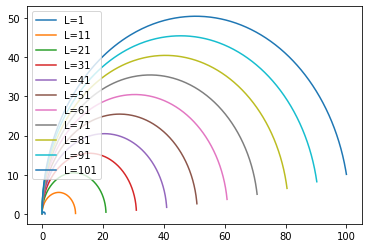

In [22]:
lambda_ps,L_ps = np.arange(0.1,1000,1), np.arange(1,102,10)
plt.figure();
for L in L_ps:
    sigs,xs,ys = [],[],[]
    for l in lambda_ps:
        sig = PM.S()
        sig.set_sigma_values(l,L)
        sigs.append(sig.get_sigma_values())
    xs = [s[0] for s in sigs]
    ys = [s[1] for s in sigs]
    plt.plot(xs,ys, label="L={}".format(L));
plt.legend()